# Crypto Currencies Predictions with LSTM

- https://steemit.com/python/@marketstack/how-to-download-historical-price-data-from-binance-with-python
- https://medium.com/better-programming/easiest-way-to-use-the-bitmex-api-with-python-fbf66dc38633
- https://sammchardy.github.io/binance/2018/01/08/historical-data-download-binance.html
- https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/
- https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
- https://arxiv.org/pdf/1912.11166.pdf#:~:text=Machine%20learning%20models%20like%20recurrent,engineering%20to%20predict%20future%20pricing.
- https://towardsdatascience.com/bitcoin-price-prediction-using-lstm-9eb0938c22bd
- https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
- https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html
- https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e

```
pip install python-binance
pip install keras
```

In [1]:
import requests        # for making http requests to binance
import json            # for parsing what binance sends back to us
import pandas as pd    # for storing and manipulating the data we get back
import numpy as np     # numerical python
import matplotlib.pyplot as plt # for charts and such
from datetime import datetime  # for dealing with times
import dateparser
import pytz
import time
from binance.client import Client
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import math

import keras

Text(0, 0.5, 'USD')

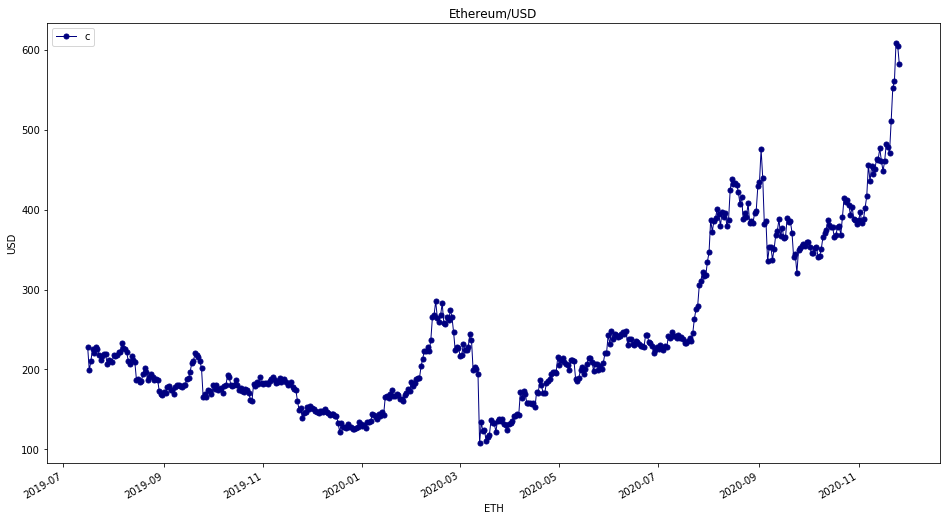

In [2]:
# This is one way to get ETH - USD data
def get_bars(symbol, interval = '1d'):
   root_url = 'https://api.binance.com/api/v3/klines'
   url = root_url + '?symbol=' + symbol + '&interval=' + interval
   data = json.loads(requests.get(url).text)
   df = pd.DataFrame(data)
   df.columns = ['open_time',
                 'o', 'h', 'l', 'c', 'v',
                 'close_time', 'qav', 'num_trades',
                 'taker_base_vol', 'taker_quote_vol', 'ignore']
   df.index = [datetime.fromtimestamp(x/1000.0) for x in df.close_time]
   return df

steemeth = get_bars('STEEMETH')
ethusdt = get_bars('ETHUSDT')
ethusdt_c = ethusdt['c'].astype('float')
steemusdt = steemeth['c'].astype('float') * ethusdt['c'].astype('float')

ax = ethusdt_c.plot(lw=1, colormap='jet', marker='.', markersize=10,figsize=(16,9),x='ETH',y='USD',legend=True,title='Ethereum/USD')
ax.set_xlabel("ETH")
ax.set_ylabel("USD")

In [3]:
# Fetch full crypto data from Binance
def date_to_milliseconds(date_str):
    """Convert UTC date to milliseconds
    If using offset strings add "UTC" to date string e.g. "now UTC", "11 hours ago UTC"
    See dateparse docs for formats http://dateparser.readthedocs.io/en/latest/
    :param date_str: date in readable format, i.e. "January 01, 2018", "11 hours ago UTC", "now UTC"
    :type date_str: str
    """
    # get epoch value in UTC
    epoch = datetime.utcfromtimestamp(0).replace(tzinfo=pytz.utc)
    # parse our date string
    d = dateparser.parse(date_str)
    # if the date is not timezone aware apply UTC timezone
    if d.tzinfo is None or d.tzinfo.utcoffset(d) is None:
        d = d.replace(tzinfo=pytz.utc)

    # return the difference in time
    return int((d - epoch).total_seconds() * 1000.0)

def interval_to_milliseconds(interval):
    """Convert a Binance interval string to milliseconds
    :param interval: Binance interval string 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w
    :type interval: str
    :return:
         None if unit not one of m, h, d or w
         None if string not in correct format
         int value of interval in milliseconds
    """
    ms = None
    seconds_per_unit = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }

    unit = interval[-1]
    if unit in seconds_per_unit:
        try:
            ms = int(interval[:-1]) * seconds_per_unit[unit] * 1000
        except ValueError:
            pass
    return ms

def get_historical_klines(symbol, interval, start_str, end_str=None):
    """Get Historical Klines from Binance
    See dateparse docs for valid start and end string formats http://dateparser.readthedocs.io/en/latest/
    If using offset strings for dates add "UTC" to date string e.g. "now UTC", "11 hours ago UTC"
    :param symbol: Name of symbol pair e.g BNBBTC
    :type symbol: str
    :param interval: Binance Kline interval
    :type interval: str
    :param start_str: Start date string in UTC format
    :type start_str: str
    :param end_str: optional - end date string in UTC format
    :type end_str: str
    :return: list of OHLCV values
    """
    # create the Binance client, no need for api key
    client = Client("", "")

    # init our list
    output_data = []

    # setup the max limit
    limit = 1000

    # convert interval to useful value in seconds
    timeframe = interval_to_milliseconds(interval)

    # convert our date strings to milliseconds
    start_ts = date_to_milliseconds(start_str)

    # if an end time was passed convert it
    end_ts = None
    if end_str:
        end_ts = date_to_milliseconds(end_str)

    idx = 0
    # it can be difficult to know when a symbol was listed on Binance so allow start time to be before list date
    symbol_existed = False
    while True:
        # fetch the klines from start_ts up to max 500 entries or the end_ts if set
        temp_data = client.get_klines(
            symbol=symbol,
            interval=interval,
            limit=limit,
            startTime=start_ts,
            endTime=end_ts
        )

        # handle the case where our start date is before the symbol pair listed on Binance
        if not symbol_existed and len(temp_data):
            symbol_existed = True

        if symbol_existed:
            # append this loops data to our output data
            output_data += temp_data

            # update our start timestamp using the last value in the array and add the interval timeframe
            start_ts = temp_data[len(temp_data) - 1][0] + timeframe
        else:
            # it wasn't listed yet, increment our start date
            start_ts += timeframe

        idx += 1
        # check if we received less than the required limit and exit the loop
        if len(temp_data) < limit:
            # exit the while loop
            break

        # sleep after every 3rd call to be kind to the API
        if idx % 3 == 0:
            time.sleep(1)

    return output_data

In [4]:
klines = get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_6HOUR, "1 Jan, 2017")
df = pd.DataFrame(klines)
df.columns = ['open_time',
             'o', 'h', 'l', 'c', 'v',
             'close_time', 'qav', 'num_trades',
             'taker_base_vol', 'taker_quote_vol', 'ignore']
df.index = [datetime.fromtimestamp(x/1000.0) for x in df.close_time]

Text(0, 0.5, 'USD')

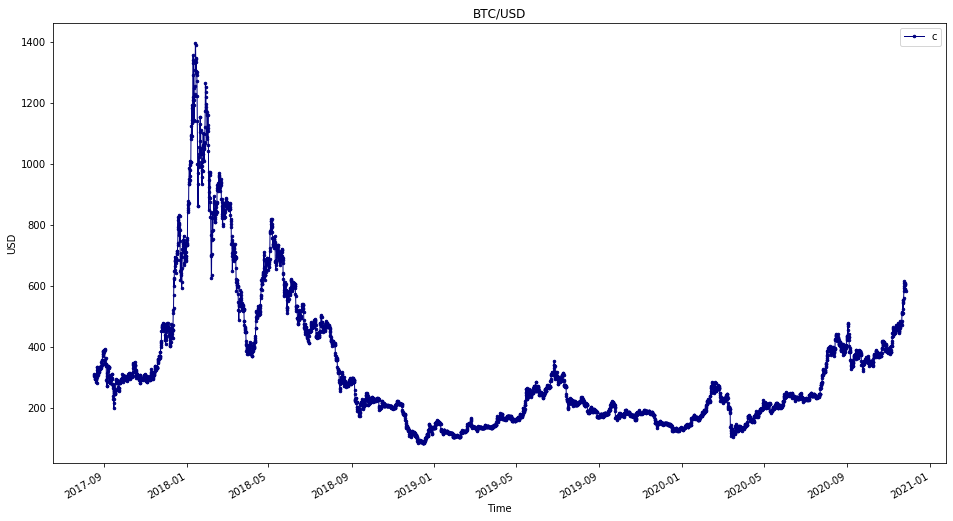

In [5]:
df_c = df['c'].astype('float')
ax = df_c.plot(lw=1, colormap='jet', marker='.', markersize=5,figsize=(16,9),legend=True,title='BTC/USD')
ax.set_xlabel("Time")
ax.set_ylabel("USD")

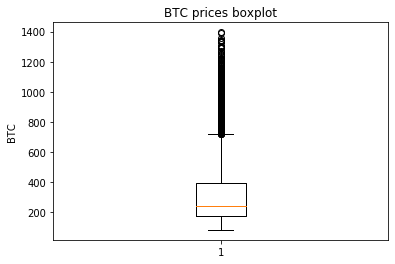

In [6]:
plt.boxplot(df['c'].astype('float').to_numpy())
plt.ylabel("BTC")
plt.title("BTC prices boxplot")
plt.show()

The input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

- *Samples*. One sequence is one sample. A batch is comprised of one or more samples.
- *Time Steps*. One time step is one point of observation in the sample.
- *Features*. One feature is one observation at a time step.

In [7]:
# Hyper parameters
timesteps = 200

# Get dataset
dataset = df['c'].astype('float').to_numpy().reshape((-1,1))

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) # Scale between 0 and 1
dataset = scaler.fit_transform(dataset)

# Split in x samples of length 100, remove the part that doesn't reach timesteps at the beginning of sequence
X = []
Y = []
for i in range(len(dataset) % timesteps + 1,len(dataset)-timesteps,timesteps):
    X.append(dataset[i-1:i+timesteps-1])
    Y.append(dataset[i+timesteps])
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(22, 200, 1)
(22, 1)


In [8]:
# Split train and test data
trainSplit = int(len(X) * 0.67)
trainX = X[0:trainSplit]
trainY = Y[0:trainSplit]
testX = X[trainSplit:]
testY = Y[trainSplit:]
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(14, 200, 1)
(14, 1)
(8, 200, 1)
(8, 1)


In [9]:
# define model
model = keras.models.Sequential()
model.add(keras.layers.LSTM(20, input_shape=(timesteps,1),return_sequences=True, dropout=0.2)) # 500 time step, 1 feature , return_sequences=True
model.add(keras.layers.LSTM(20, input_shape=(timesteps,1),return_sequences=True, dropout=0.2)) # 500 time step, 1 feature , return_sequences=True
model.add(keras.layers.LSTM(20, input_shape=(timesteps,1),return_sequences=True, dropout=0.2)) # 500 time step, 1 feature , return_sequences=True
model.add(keras.layers.LSTM(20, input_shape=(timesteps,1),return_sequences=True, dropout=0.2)) # 500 time step, 1 feature , return_sequences=True
model.add(keras.layers.LSTM(20, input_shape=(timesteps,1),return_sequences=True, dropout=0.2)) # 500 time step, 1 feature , return_sequences=True
model.add(keras.layers.LSTM(20, input_shape=(timesteps,1),return_sequences=True, dropout=0.2)) # 500 time step, 1 feature , return_sequences=True
model.add(keras.layers.LSTM(20, input_shape=(timesteps,1), dropout=0.2)) # 500 time step, 1 feature , return_sequences=True
model.add(keras.layers.Dense(30,activation='relu'))
model.add(keras.layers.Dense(1, activation='relu')) # 1 or more samples
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200, 20)           1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 20)           3280      
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 20)           3280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 200, 20)           3280      
_________________________________________________________________
lstm_4 (LSTM)                (None, 200, 20)           3280      
_________________________________________________________________
lstm_5 (LSTM)                (None, 200, 20)           3280      
_________________________________________________________________
lstm_6 (LSTM)                (None, 20)                3

In [10]:
# Compile model
# Root mean squared error (RMSE) is preferred over mean absolute error (MAE) for model error evaluation 
# because RMSE gives relatively high weight to large errors. 
def root_mean_squared_error(y_true, y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true))) 
# opt = keras.optimizers.Adam(learning_rate=0.1)
# model.compile(loss='mse', optimizer=opt)
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
history = model.fit(trainX, trainY, epochs=300, shuffle=False, verbose=1)
# Save model to single file
# Later, perhaps run from another script
model.save('lstm_model.h5')

Epoch 1/300
1/1 [==============================] - 0s 896us/step - loss: 0.1218 - mae: 0.2453
Epoch 2/300
1/1 [==============================] - 0s 797us/step - loss: 0.1178 - mae: 0.2383
Epoch 3/300
1/1 [==============================] - 0s 786us/step - loss: 0.1125 - mae: 0.2285
Epoch 4/300
1/1 [==============================] - 0s 840us/step - loss: 0.1061 - mae: 0.2155
Epoch 5/300
1/1 [==============================] - 0s 785us/step - loss: 0.0977 - mae: 0.2019
Epoch 6/300
1/1 [==============================] - 0s 795us/step - loss: 0.0886 - mae: 0.1869
Epoch 7/300
1/1 [==============================] - 0s 1000us/step - loss: 0.0800 - mae: 0.1720
Epoch 8/300
1/1 [==============================] - 0s 790us/step - loss: 0.0691 - mae: 0.1603
Epoch 9/300
1/1 [==============================] - 0s 789us/step - loss: 0.0600 - mae: 0.1561
Epoch 10/300
1/1 [==============================] - 0s 795us/step - loss: 0.0492 - mae: 0.1609
Epoch 11/300
1/1 [==============================] - 0s 823

1/1 [==============================] - 0s 818us/step - loss: 0.0085 - mae: 0.0619
Epoch 88/300
1/1 [==============================] - 0s 931us/step - loss: 0.0078 - mae: 0.0579
Epoch 89/300
1/1 [==============================] - 0s 881us/step - loss: 0.0042 - mae: 0.0424
Epoch 90/300
1/1 [==============================] - 0s 849us/step - loss: 0.0103 - mae: 0.0678
Epoch 91/300
1/1 [==============================] - 0s 844us/step - loss: 0.0040 - mae: 0.0376
Epoch 92/300
1/1 [==============================] - 0s 823us/step - loss: 0.0074 - mae: 0.0553
Epoch 93/300
1/1 [==============================] - 0s 887us/step - loss: 0.0091 - mae: 0.0613
Epoch 94/300
1/1 [==============================] - 0s 905us/step - loss: 0.0087 - mae: 0.0620
Epoch 95/300
1/1 [==============================] - 0s 882us/step - loss: 0.0036 - mae: 0.0396
Epoch 96/300
1/1 [==============================] - 0s 883us/step - loss: 0.0052 - mae: 0.0480
Epoch 97/300
1/1 [==============================] - 0s 876us/st

1/1 [==============================] - 0s 880us/step - loss: 0.0029 - mae: 0.0425
Epoch 173/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0312
Epoch 174/300
1/1 [==============================] - 0s 867us/step - loss: 0.0029 - mae: 0.0404
Epoch 175/300
1/1 [==============================] - 0s 864us/step - loss: 0.0041 - mae: 0.0422
Epoch 176/300
1/1 [==============================] - 0s 925us/step - loss: 0.0046 - mae: 0.0454
Epoch 177/300
1/1 [==============================] - 0s 916us/step - loss: 0.0024 - mae: 0.0389
Epoch 178/300
1/1 [==============================] - 0s 862us/step - loss: 0.0043 - mae: 0.0411
Epoch 179/300
1/1 [==============================] - 0s 867us/step - loss: 0.0057 - mae: 0.0498
Epoch 180/300
1/1 [==============================] - 0s 868us/step - loss: 0.0040 - mae: 0.0364
Epoch 181/300
1/1 [==============================] - 0s 875us/step - loss: 0.0087 - mae: 0.0633
Epoch 182/300
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 915us/step - loss: 0.0068 - mae: 0.0586
Epoch 258/300
1/1 [==============================] - 0s 900us/step - loss: 0.0021 - mae: 0.0271
Epoch 259/300
1/1 [==============================] - 0s 900us/step - loss: 0.0039 - mae: 0.0439
Epoch 260/300
1/1 [==============================] - 0s 778us/step - loss: 0.0023 - mae: 0.0339
Epoch 261/300
1/1 [==============================] - 0s 854us/step - loss: 0.0021 - mae: 0.0337
Epoch 262/300
1/1 [==============================] - 0s 775us/step - loss: 0.0033 - mae: 0.0378
Epoch 263/300
1/1 [==============================] - 0s 882us/step - loss: 0.0016 - mae: 0.0294
Epoch 264/300
1/1 [==============================] - 0s 825us/step - loss: 0.0022 - mae: 0.0364
Epoch 265/300
1/1 [==============================] - 0s 845us/step - loss: 0.0040 - mae: 0.0400
Epoch 266/300
1/1 [==============================] - 0s 847us/step - loss: 0.0052 - mae: 0.0437
Epoch 267/300
1/1 [==============================] - 0

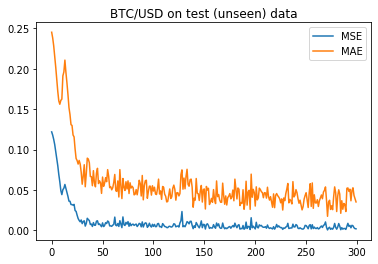

In [11]:
# Plot the loss evolution
plt.plot(history.history['loss'], label = 'MSE')
plt.plot(history.history['mae'], label = 'MAE')    
plt.title('BTC/USD on test (unseen) data')
ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
plt.legend()
plt.show()

In [12]:
# Evaluate model on test data
print(trainX.shape)
scores = model.evaluate(trainX, trainY, verbose=1)
print(scores)      

print(testX.shape)
scores = model.evaluate(testX, testY, verbose=1)
print(scores)      

(14, 200, 1)
1/1 [==============================] - 0s 761us/step - loss: 0.0019 - mae: 0.0343
[0.001876538386568427, 0.034272339195013046]
(8, 200, 1)
1/1 [==============================] - 0s 728us/step - loss: 0.0012 - mae: 0.0333
[0.0011940975673496723, 0.033337391912937164]


In [13]:
# make predictions for the x element in one sample, and predict the next elements of the next sample
# load model from single file
model = keras.models.load_model('lstm_model.h5')

# make predictions
def predictNextSample(data):
    predictions = data
    predictions = np.reshape(predictions, (predictions.shape[0],1))
    for i in range(0,timesteps):
        prediction = model.predict(np.reshape(predictions, (1,predictions.shape[0],1)), verbose=0)
        predictions = np.append(predictions, prediction[0])
        predictions = np.delete(predictions,0)
    predictions = np.reshape(predictions, (predictions.shape[0],1))
    return predictions


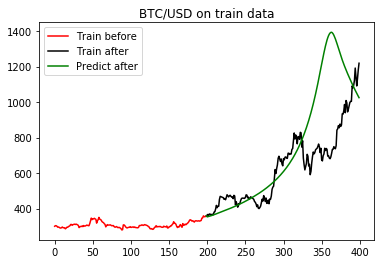

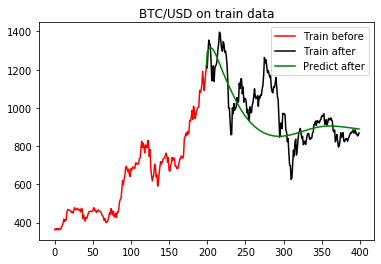

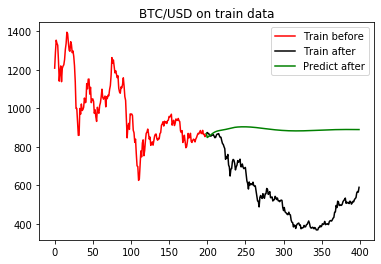

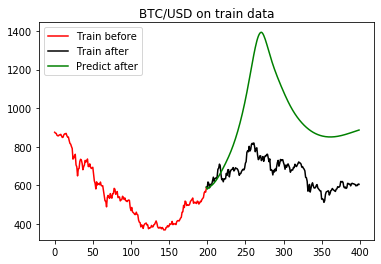

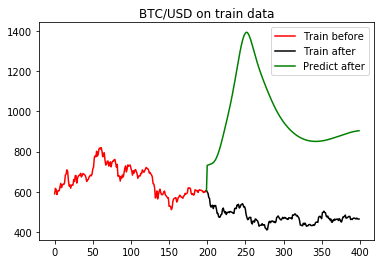

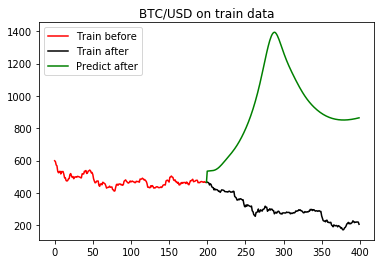

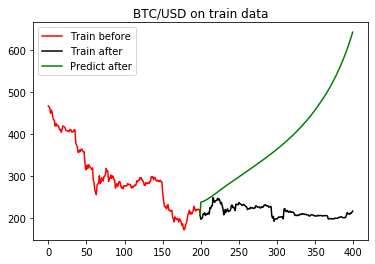

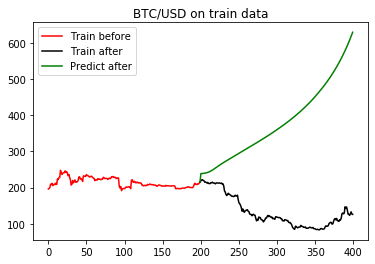

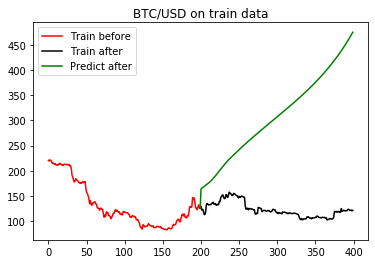

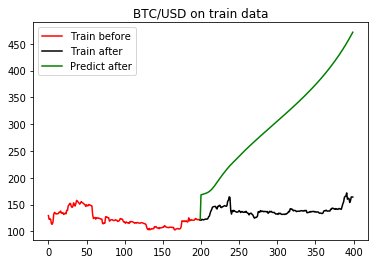

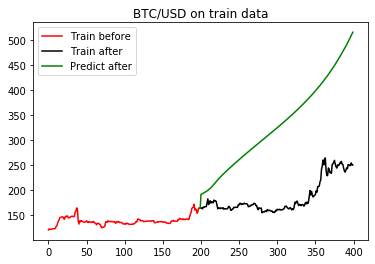

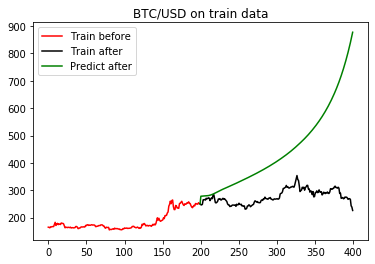

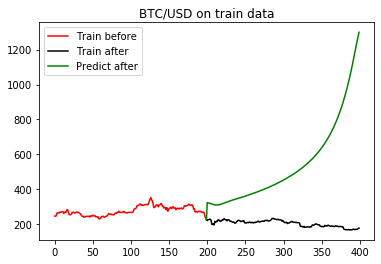

In [14]:
for i in range(0, len(trainX) - 1):
    predictions = predictNextSample(trainX[i])
    plt.plot([x for x in range(0,len(predictions))], scaler.inverse_transform(trainX[i]), color = 'red', label = 'Train before')
    plt.plot([x for x in range(len(predictions)-1,len(predictions)*2)], scaler.inverse_transform(np.insert(trainX[i+1], 0, trainX[i][-1]).reshape((timesteps+1,1))), color = 'black', label = 'Train after')
    plt.plot([x for x in range(len(predictions)-1,len(predictions)*2)], scaler.inverse_transform(np.insert(predictions, 0, trainX[i][-1]).reshape((timesteps+1,1))), color = 'green', label = 'Predict after')
    plt.title('BTC/USD on train data')
    ax.set_xlabel("Time")
    ax.set_ylabel("USD")
    plt.legend()
    plt.show()

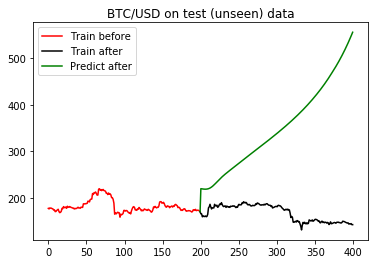

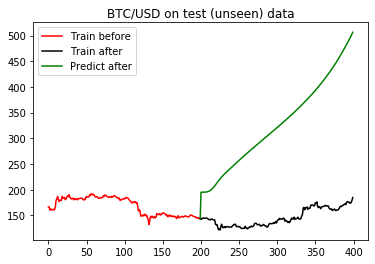

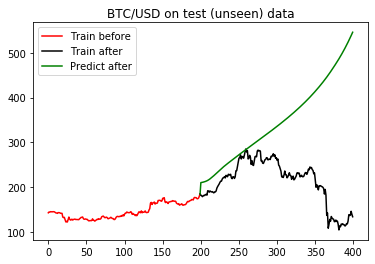

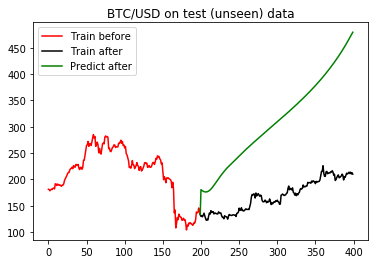

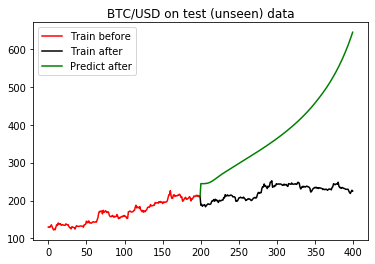

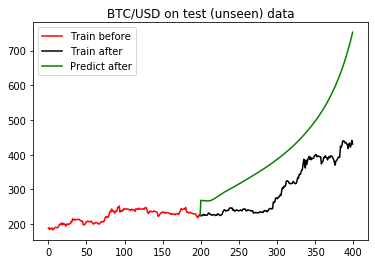

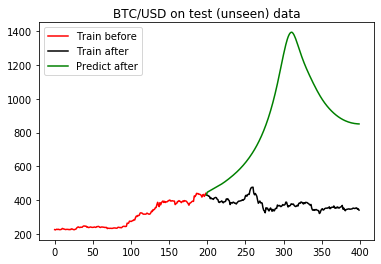

In [15]:
for i in range(0, len(testX) - 1):
    predictions = predictNextSample(testX[i])
    plt.plot([x for x in range(0,len(predictions))], scaler.inverse_transform(testX[i]), color = 'red', label = 'Train before')
    plt.plot([x for x in range(len(predictions)-1,len(predictions)*2)], scaler.inverse_transform(np.insert(testX[i+1], 0, testX[i][-1]).reshape((timesteps+1,1))), color = 'black', label = 'Train after')
    plt.plot([x for x in range(len(predictions)-1,len(predictions)*2)], scaler.inverse_transform(np.insert(predictions, 0, testX[i][-1]).reshape((timesteps+1,1))), color = 'green', label = 'Predict after')
    plt.title('BTC/USD on test (unseen) data')
    ax.set_xlabel("Time")
    ax.set_ylabel("USD")
    plt.legend()
    plt.show()

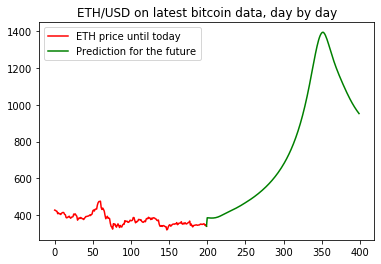

In [16]:
# Predict the future
predictions = predictNextSample(testX[-1])
plt.plot([x for x in range(0,len(predictions))], scaler.inverse_transform(testX[-1]), color = 'red', label = 'ETH price until today')
plt.plot([x for x in range(len(predictions)-1,len(predictions)*2)], scaler.inverse_transform(np.insert(predictions, 0, testX[-1][-1]).reshape((timesteps+1,1))), color = 'green', label = 'Prediction for the future')
plt.title('ETH/USD on latest bitcoin data, day by day')
ax.set_xlabel("Time")
ax.set_ylabel("USD")
plt.legend()
plt.show()